# Project 1 Part 1: News article classification with TF-IDF, GloVe, and LLM embeddings

Note: use conda activate ece219

In [1]:
import pandas as pd
df = pd.read_csv('Project1-ClassificationDataset.csv')

## Question 1 -Dataset Examination

Let's examine the dataset to see how many rows (samples) and columns (features) are present in the dataset.

In [2]:
count_rows, count_columns = df.shape
print(f"{count_rows} rows, {count_columns} columns")

3476 rows, 8 columns


In [3]:
df.head(5)

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


Now I'll plot 3 histograms on
(a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;
(b) The column leaf label – class on the x-axis; 
(c) The column root label – class on the x-axis.

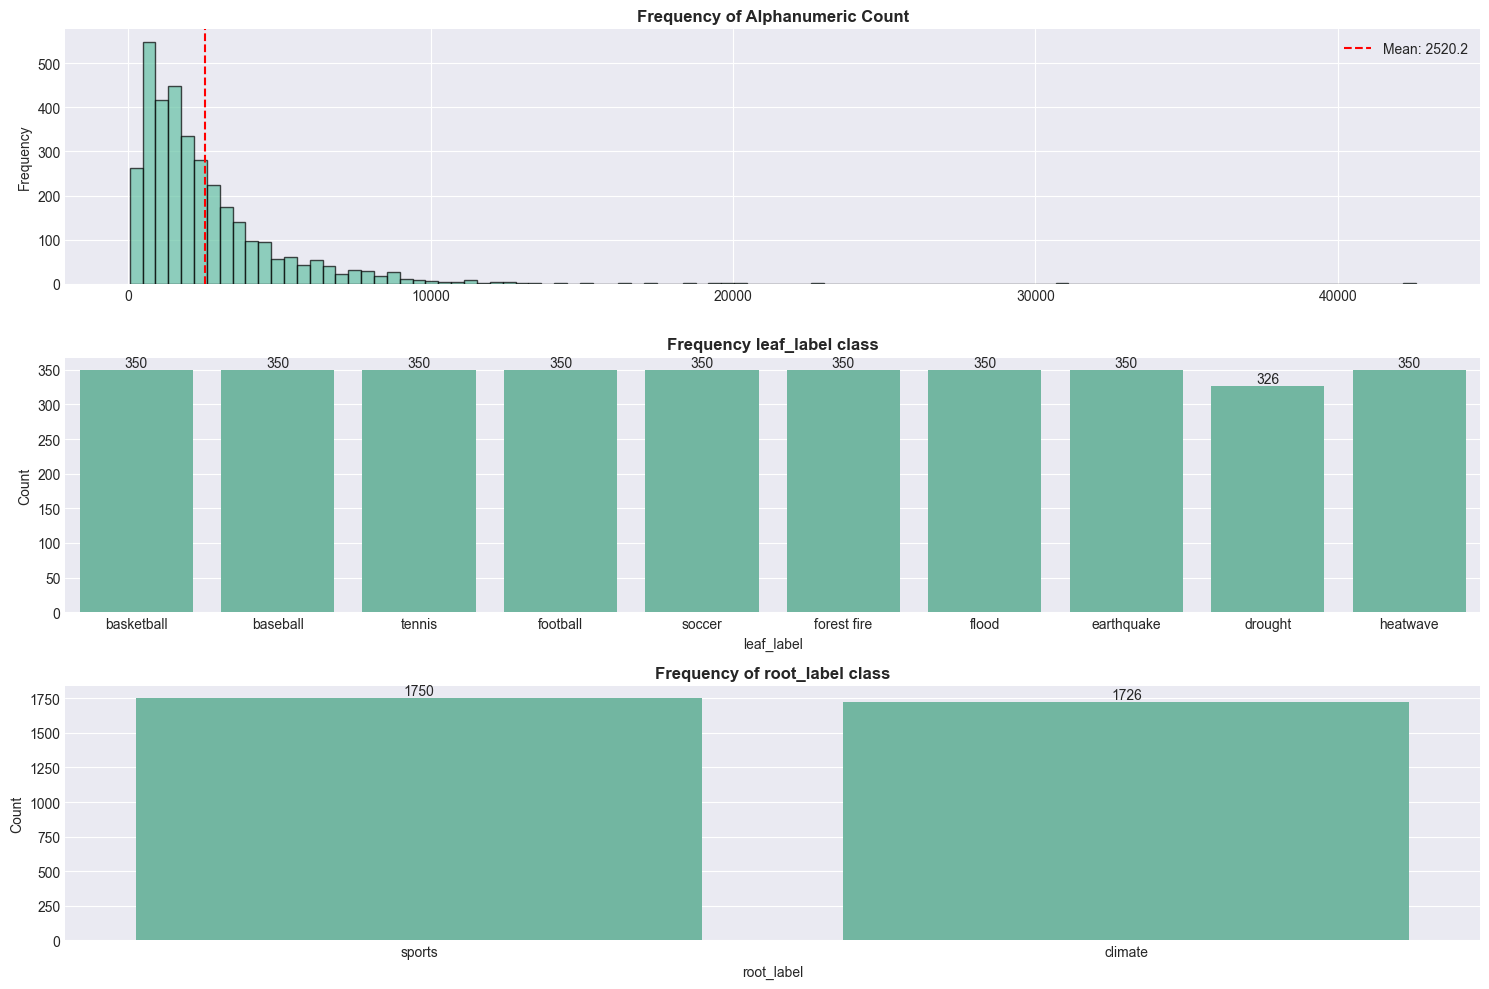

More statistics on alphanumeric character count:
Mean: 2520
Median: 1807
Std Dev: 2454
Min: 42
Max: 42580


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# histograms
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# alphanumeric chars
df["count_alnum"] = df["full_text"].str.count(r"[A-Za-z0-9]")
axes[0].set_title('Frequency of Alphanumeric Count', fontsize=12, fontweight='bold')
axes[0].hist(df["count_alnum"], bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(df['count_alnum'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["count_alnum"].mean():.1f}')
axes[0].set_ylabel('Frequency')
axes[0].legend()

#column leaf_label
sns.countplot(data=df, x='leaf_label', ax=axes[1])
axes[1].set_title('Frequency leaf_label class', fontsize=12, fontweight='bold')
for container in axes[1].containers:
    axes[1].bar_label(container)
axes[1].set_ylabel('Count')
    
#column root_label
sns.countplot(data=df, x='root_label', ax=axes[2])
axes[2].set_title('Frequency of root_label class', fontsize=12, fontweight='bold')
for container in axes[2].containers:
    axes[2].bar_label(container)
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


print(f"More statistics on alphanumeric character count:")
print(f"Mean: {df['count_alnum'].mean():.0f}")
print(f"Median: {df['count_alnum'].median():.0f}")
print(f"Std Dev: {df['count_alnum'].std():.0f}")
print(f"Min: {df['count_alnum'].min():.0f}")
print(f"Max: {df['count_alnum'].max():.0f}")


### Initial Qualitative Analysis

Our dataset contains news articles that fall under one of two root_labels: sports or climate. There are 1750 sports articles and 1725 climate articles. The articles are additionally tagged with a leaf label that further categorizes the article. For each leaf_label class present in the dataset, there are 350 articles, with the exception of "drought" which only has 326 articles. So notably, "drought" is less represented in the dataset than the other leaf_labels. By extension, "climate" is less represented than the other root label "sports". Lastly, the distribution of alphanumeric length of articles is right-skewed, meaning the articles are relatively short. The mean count of alphanumeric characters in articles is 2520. 

## Question 2 - Number of Training / Testing Samples
Let's split the data and report the number of training and testing samples.

In [5]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
df[["full_text", "root_label", "leaf_label"]],
test_size=0.2
)
print(f"{train.shape[0]} training samples, {test.shape[0]} testing samples")

2780 training samples, 696 testing samples


## Question 3 - Extracting Features
Now we will clean / tokenize / lemmatize the data and create a pipeline 

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import nltk
#needed for WordNetLemmatizer and pos_tag
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')

def get_wordnet_pos(tag):
    # Converts Penn Treebank tags to WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# lemmatizer tokenizer
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if re.match(r'\b[^\d\W]+\b', t)]
        pos_tags = pos_tag(tokens)
        return [self.lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]

# stemming tokenizer
class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if re.match(r'\b[^\d\W]+\b', t)]
        return [self.stemmer.stem(token) for token in tokens]

train['full_text_cleaned'] = train["full_text"].apply(clean)
test['full_text_cleaned'] = test["full_text"].apply(clean)

#stemming pipeline + results
print("Stemming:")
tfidf_pipeline_stem = Pipeline([
    ('count', CountVectorizer(
        tokenizer=StemTokenizer(),
        stop_words='english',
        min_df=3
    )),
    ('tfidf', TfidfTransformer())
])

#fit/ transform
train_tfidf_stem = tfidf_pipeline_stem.fit_transform(train['full_text_cleaned'])
test_tfidf_stem = tfidf_pipeline_stem.transform(test['full_text_cleaned'])

print(f"Train TF-IDF Stemming shape: {train_tfidf_stem.shape}")
print(f"Test TF-IDF Stemming shape: {test_tfidf_stem.shape}")
print(f"Vocab size Stemming: {len(tfidf_pipeline_stem.named_steps['count'].vocabulary_)}")



#Lemmatization pipeline + results
print("Lemmatizing:")
tfidf_pipeline_lemma = Pipeline([
    ('count', CountVectorizer(
        tokenizer=LemmaTokenizer(),
        stop_words='english',
        min_df=3
    )),
    ('tfidf', TfidfTransformer())
])

#fit/ transform
train_tfidf_lemma = tfidf_pipeline_lemma.fit_transform(train['full_text_cleaned'])
test_tfidf_lemma = tfidf_pipeline_lemma.transform(test['full_text_cleaned'])


print(f"Train TF-IDF Lemmatizing shape: {train_tfidf_lemma.shape}")
print(f"Test TF-IDF Lemmatizing shape: {test_tfidf_lemma.shape}")
print(f"Vocab size Lemmatizing: {len(tfidf_pipeline_lemma.named_steps['count'].vocabulary_)}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data.

Stemming:


C:\Users\jilli\.conda\envs\ece219\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\jilli\.conda\envs\ece219\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 

Train TF-IDF Stemming shape: (2780, 11999)
Test TF-IDF Stemming shape: (696, 11999)
Vocab size Stemming: 11999
Lemmatizing:


C:\Users\jilli\.conda\envs\ece219\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


Train TF-IDF Lemmatizing shape: (2780, 15306)
Test TF-IDF Lemmatizing shape: (696, 15306)
Vocab size Lemmatizing: 15306


**1. What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?**
- Stemming uses simple rules to chop off word endings so its simpler to implement but can result in errors (for example "organ", "organizational", and "organic" would all become "organ" resulting in merging the representation of seperate concepts, so it is less accurate in practice. Lemmatization on the other hand uses vocab analysis, so concepts like "organ", "organizational", and "organic" are kept seperate because when combined with their part-of-speech tag, they'll have different dictionary entries and are recognized as distinct words with different meanings. However the vocab analysis makes the method slower and more computationally intense since this requires POS-tagging and dictionary lookups. Lemmatization also results in larger dictionaries.

**2. min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?**
- min_df is the minimum document frequency. If set to 3 this means the word must appear in at least 3 documents. If we increase this value (say set to 10) we will get a smaller vocab size (fewer columns in the TF-IDF matrix). If we decrease this value (say set to 1) we will get a larger vocab size (more columns in the TF-IDF matrix). In general, increasing this value can remove rare words and reduce noise but can also cause information loss if set too high. Decreasing this value will keep more rare words, increase noise and can lead to the model learning overly-specific-to-one-document vocabulary (overfitting). 

**3. Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall
that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position
of every word based on the sentence structure.**
- Do all of these removals after lemmatizing. Lemmatization needs the full sentence context (including stopwords, punctuation, and numbers) to have the best chance of lemmatizing correctly. Removing this context can result in incorrect lemmatization because the POS tagger may not be able to determin what POS a word is.

**4. Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing
and that is okay.**
- This is printed above. Vocab size is ~11k for stemmed matrices and ~15k for the lemmatized matrices.

## Question 4 - GloVE Paper

Below are answers to questions about the GloVE paper https://nlp.stanford.edu/pubs/glove.pdf

**a. Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?**
By training on co-occurence probabilities, GloVE captures captures semantic relationships. In particular, it captures what is discriminative about word-word relationships. (e.g., the ratio P(solid|ice)/P(solid|steam) is large because "solid" relates to ice but not steam and the raw probabilities P(solid|ice) and P(solid|steam) in isolation don't reveal this contrast.

**b. In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?**
Yes, because GloVE has one embedding per word, not per word occurrence. This embedding is learned from global co-occurence statistics across the entire training corpus. During training, if the word "running" appeared, it would use the same vector even if the context is different!

**c. What do you expect for the values of,
||GLoVE["left"] - GLoVE["right"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and
||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.**
"left" and "right" would appear in similar contexts, as would "wife" and "husband", so we would expect ||GLoVE["left"] - GLoVE["right"]|| and ||GLoVE["wife"] - GLoVE["husband"]||  would be very small (close to 0). Alternatively, ||GLoVE["wife"] - GLoVE["orange"]|| would be large because "wife" and "orange" do not occur in similar contexts.

**d. Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE
embedding?**
You would rather do lemmatization before mapping it to its glove embedding if using a pretrained GloVE model. Since stemming returns word stems instead of real words, and GloVe embeddings are trained on real word forms, it makes sense to prefer lemmatization as lemmatization maps a word to its canonical dictionary form which is more likely to exist as-is in the GloVe vocabulary. If training a GloVE model from scratch you could use stemming, but there are downsides to this approach as well: since stemming merges unrelated word forms, this introduces semantic notise into the co-occurance probabilities that GloVe relies on. 

## Question 5 - GLoVE Feature Construction Pipeline

Below is a description of the pipeline I'm using:

**1. Preprocessing:** Uses full_text_cleaned (pre-cleaned text from previous question), tokenizes, lowercases, and lemmatizes using WordNet lemmatizer with POS tagging. Stopwords and non-alphabetic tokens are removed.

**2. Word Vector Lookup:** For each preprocessed token, retrieve its corresponding 300-dimensional GloVe vector from the pretrained glove.6B.300d embeddings. I choose to just skip any out-of-vocab words (OOV).

**3. Normalization:** Each word vector is L2-normalized to unit length.

**4. Aggregation:** The document embedding is computed as the arithmetic mean of all normalized word vectors in the document. This produces a single 300-dimensional vector per document.

**Note**: Documents with no in-vocabulary words receive a zero vector.

In [9]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

### Pipeline Implementation

In [10]:
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
import nltk

nltk.download('stopwords')

class GloVeEmbedder:
    def __init__(self, embeddings_dict):
        self.embeddings_dict = embeddings_dict
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.embedding_dim = len(next(iter(embeddings_dict.values())))
        
    def preprocess(self, text):
        #tokenize, lemmtize, filter out nonalphanumeric
        tokens = word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        #lemmatize
        lemmatized = [
            self.lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
            for token, tag in pos_tags
        ]
        filtered = [
            word for word in lemmatized 
            if word.isalpha() and 
               len(word) > 1 and 
               (word not in self.stop_words)
        ]
        return filtered
    
    def embed_doc(self, text):
        #Convert a document to embedding vector
        tokens = self.preprocess(text)
        word_vectors = []
        oov_count = 0
        
        for token in tokens:
            if token in self.embeddings_dict:
                vec = self.embeddings_dict[token]
                word_vectors.append(vec)
            else:
                oov_count += 1
        
        # if no valid words
        if len(word_vectors) == 0:
            print(f"WARNING: Document with no valid words. Sample tokens: {tokens[:5]}")
            return np.zeros(self.embedding_dim), 1.0
        
        #get word vectors and normalize + avg
        word_vectors = np.array(word_vectors)
        word_vectors = normalize(word_vectors, axis=1, norm='l2')
        doc_embedding = np.mean(word_vectors, axis=0)
        
        #find OOV rate
        total_tokens = len(tokens)
        oov_rate = oov_count / total_tokens if total_tokens > 0 else 0
        return doc_embedding, oov_rate
    
    def transform(self, documents):
        #Transform list of documents to embedding matrix
        embeddings = []
        oov_rates = []
        
        for i, doc in enumerate(documents):
            emb, oov = self.embed_doc(doc)
            embeddings.append(emb)
            oov_rates.append(oov)
        return np.array(embeddings), np.array(oov_rates)


print("Creating doc embedder...")
embedder = GloVeEmbedder(
    embeddings_dict=embeddings_dict,
)

#transform train and test
print("Transforming training documents...")
train_glove_emb, train_oov_rates = embedder.transform(train['full_text_cleaned'])

print("Transforming test documents...")
test_glove_emb, test_oov_rates = embedder.transform(test['full_text_cleaned'])

#Part(b): Report results
print(f"\nTrain GloVe embeddings shape: {train_glove_emb.shape}")
print(f"Test GloVe embeddings shape: {test_glove_emb.shape}")
print(f"\nAverage OOV rate (train): {np.mean(train_oov_rates):.2%}")
print(f"Average OOV rate (test): {np.mean(test_oov_rates):.2%}")
print(f"Median OOV rate (train): {np.median(train_oov_rates):.2%}")
print(f"Median OOV rate (test): {np.median(test_oov_rates):.2%}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creating doc embedder...
Transforming training documents...
Transforming test documents...

Train GloVe embeddings shape: (2780, 300)
Test GloVe embeddings shape: (696, 300)

Average OOV rate (train): 1.34%
Average OOV rate (test): 1.38%
Median OOV rate (train): 0.89%
Median OOV rate (test): 0.97%


## Question 6 Using LLM Encoder Embeddings
Below is my code that uses a pretrained model "all-MiniLM-L6-v2" to compute vector embeddings. I had trouble running the LLM helper code for this part and got something similar to work that imports SentenceTransformer library explicitly. The code uses SentenceTransformers encode() method to get the embeddings which does truncation by default, however, I have increased the max_seq_length to be 512 to make it better suited to this task. My justification for using the truncation method is that most key information in a news article can usually be found at the beginning of the article. I think the first few sentences of an article will be enough for a classifier to be able to tell whether the article is about climate or sports. Additionally, this method is simpler to implement.

In [11]:

from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm

MODEL_NAME = "all-MiniLM-L6-v2"

print("Loading model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(MODEL_NAME, device=device)
print(f"Model loaded on this device: {device}")

def encode_texts(texts, batch_size=32):
#utilize sentence-transformers library to encode texts (truncation method used automatically)
    model.max_seq_length = 512  # Set truncation max_se_length to 512
    print(f"Encoding {len(texts)} documents...")
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    return torch.from_numpy(embeddings)

print("encoding training set")
train_transformer = encode_texts(train['full_text_cleaned'].tolist())
print("encoding test set")
test_transformer = encode_texts(test['full_text_cleaned'].tolist())

print(f"\nTransformer Train shape: {train_transformer.shape}")
print(f"Transformer Test shape: {test_transformer.shape}")
print(f"Embedding dimension: {train_transformer.shape[1]}")

Loading model...
Model loaded on this device: cuda
encoding training set
Encoding 2780 documents...


Batches:   0%|          | 0/87 [00:00<?, ?it/s]

encoding test set
Encoding 696 documents...


Batches:   0%|          | 0/22 [00:00<?, ?it/s]


Transformer Train shape: torch.Size([2780, 384])
Transformer Test shape: torch.Size([696, 384])
Embedding dimension: 384


## Question 7 - Dimensionality Reduction

In this section I fit annd LSI and NMF model on the training TF-IDF matrix and compare.

Fitting for k = 1
Fitting for k = 5
Fitting for k = 10
Fitting for k = 25
Fitting for k = 50
Fitting for k = 100
Fitting for k = 500
Fitting for k = 1000


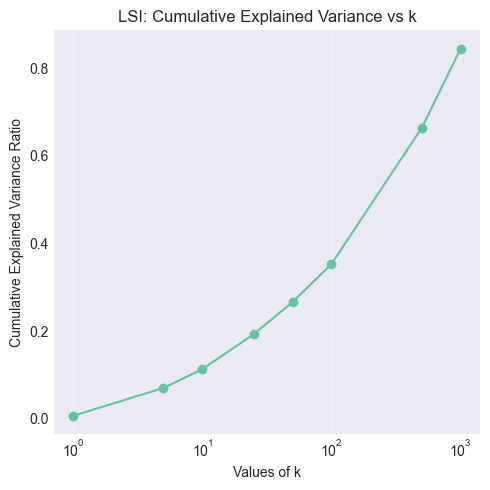


LSI TFIDF Train shape: (2780, 25)

LSI TFIDF Test shape: (696, 25)


In [12]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

k_vals = [1, 5, 10, 25, 50, 100, 500, 1000]
cumulative_variances = []

for k in k_vals:
    print(f"Fitting for k = {k}")
    svd = TruncatedSVD(n_components=k, random_state=0)
    svd.fit(train_tfidf_lemma)
    if k == 25:
        svd25 = svd
        lsi_tfidf_lemma_train = svd.transform(train_tfidf_lemma)
        lsi_tfidf_lemma_test = svd.transform(test_tfidf_lemma)
    cumulative_var = np.sum(svd.explained_variance_ratio_)
    cumulative_variances.append(cumulative_var)

plt.figure(figsize=(5,5))
plt.plot(k_vals, cumulative_variances, marker='o')
plt.xlabel('Values of k')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('LSI: Cumulative Explained Variance vs k')
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print(f"\nLSI TFIDF Train shape: {lsi_tfidf_lemma_train.shape}")
print(f"\nLSI TFIDF Test shape: {lsi_tfidf_lemma_test.shape}")

In [13]:
from sklearn.decomposition import NMF

nmf25 = NMF(n_components=25, init='random', random_state=0)
nmf_tfidf_lemma_train = nmf25.fit_transform(train_tfidf_lemma)
nmf_tfidf_lemma_test = nmf25.transform(test_tfidf_lemma)

print(f"\nNMF TFIDF Train shape: {nmf_tfidf_lemma_train.shape}")
print(f"\nNMF TFIDF Test shape: {nmf_tfidf_lemma_test.shape}")


NMF TFIDF Train shape: (2780, 25)

NMF TFIDF Test shape: (696, 25)


In [14]:


# compute reconstruction MSE
n, m = train_tfidf_lemma.shape

#Lsi
X_lsi = svd25.inverse_transform(lsi_tfidf_lemma_train)
mse_lsi = np.sum((train_tfidf_lemma.toarray() - X_lsi)**2) / (n * m)

# NMF
X_nmf = nmf25.inverse_transform(nmf_tfidf_lemma_train)
mse_nmf = np.sum((train_tfidf_lemma.toarray() - X_nmf)**2) / (n * m)

print(f"LSI Reconstruction MSE: {mse_lsi:.10f}")
print(f"NMF Reconstruction MSE: {mse_nmf:.10f}")

LSI Reconstruction MSE: 0.0000511210
NMF Reconstruction MSE: 0.0000515816


The LSI method has a lower reconstruction error. This is due to how SVD minimizes squared reconstruction error with no constraints. NMF, on the other hand, has a non-negativity constraint that makes it unable to reach the same optimal solution.

## Question 8 - Comparing Hard Margin vs Soft Margin linear SVMs

I train linear SVMs (hard margin, soft margin, and extra hard margin) and compare their performance

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc)

y_train = train['root_label']
y_test = test['root_label']

def train_svm(x_train, y_train, x_test, y_test, gamma):
    c = 1.0 / gamma
    svm = LinearSVC(loss='hinge',C=c, random_state = 42, max_iter = 10000)
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_test)
    #for ROC curve get decision scores
    y_scores = svm.decision_function(x_test)
    
    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='sports')
    recall = recall_score(y_test, y_pred, pos_label='sports')
    f1 = f1_score(y_test, y_pred, pos_label='sports')

    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nResults for SVM where: γ = {gamma} (C = {c})")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)

    return {
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'gamma': gamma,
        'C': c
    }

def plot_roc_curve(results_list, y_test, title):
    plt.figure(figsize=(10, 8))
    if isinstance(y_test.iloc[0], str):
        y_test_binary = (y_test == 'sports').astype(int)
    else:
        y_test_binary = y_test
    
    for result in results_list:
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test_binary, result['y_scores'])
        roc_auc = auc(fpr, tpr)
        
        # Plot
        label = f"γ={result['gamma']} (AUC={roc_auc:.3f})"
        plt.plot(fpr, tpr, linewidth=2, label=label)
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Results for SVM where: γ = 2000 (C = 0.0005)
Accuracy:  0.8391
Precision: 0.9885
Recall:    0.7038
F1-Score:  0.8222
Confusion Matrix:
[[325   3]
 [109 259]]


C:\Users\jilli\.conda\envs\ece219\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for SVM where: γ = 0.0005 (C = 2000.0)
Accuracy:  0.9411
Precision: 0.9504
Recall:    0.9375
F1-Score:  0.9439
Confusion Matrix:
[[310  18]
 [ 23 345]]

Results for SVM where: γ = 100000 (C = 1e-05)
Accuracy:  0.8391
Precision: 0.9885
Recall:    0.7038
F1-Score:  0.8222
Confusion Matrix:
[[325   3]
 [109 259]]


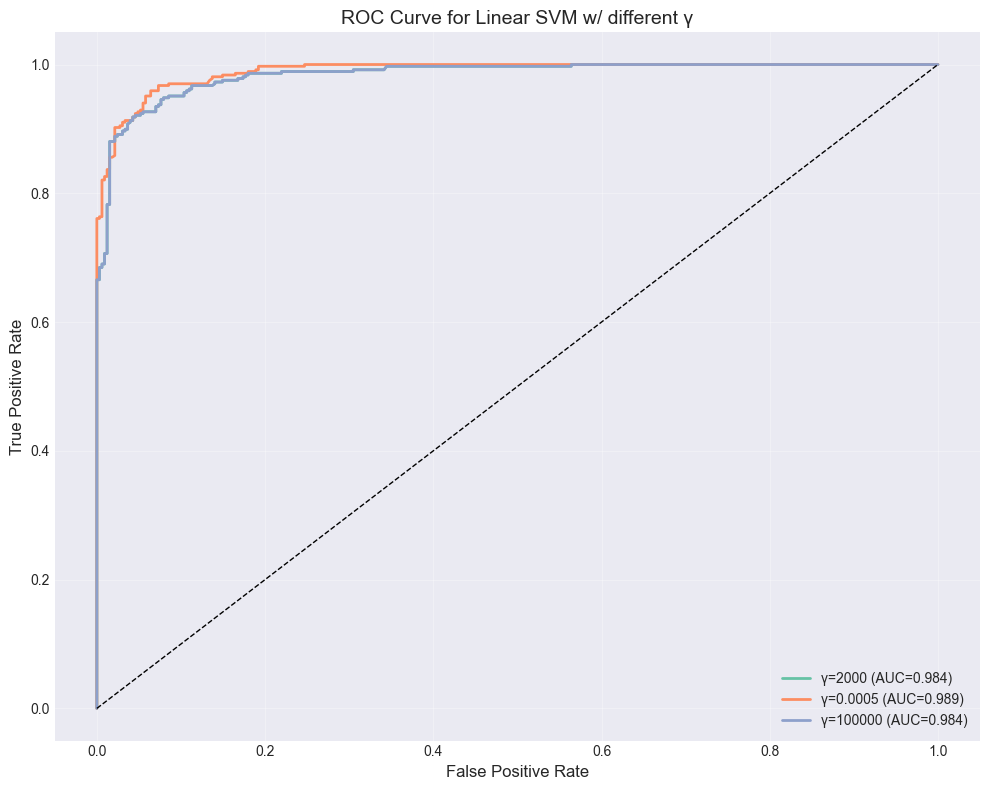

In [16]:
#Using LSI Tfidf data (where k = 25)
results_hard = train_svm(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test, gamma=2000)

results_soft = train_svm(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test, gamma=0.0005)

results_extra_hard = train_svm(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test, gamma=100000)

plot_roc_curve([results_hard, results_soft, results_extra_hard], y_test, "ROC Curve for Linear SVM w/ different γ")

### Analysis
For the hard margin SVM (γ = 2000), the confusion matrix tells us that the model is very careful about predicting the "sports" label. It only predicts the "sports" label when it is 100% certain, so it misses a lot of sports articles (109 missed).
For the soft margin SVM (γ = 0.0005), the model is able to make predictions when its less certain, so finds almost all sports articles with a few mistakes (misses 18 climate articles and finds 345/368 sports articles).
For the extra hard margin SVM (γ = 1000000), the confusion matrix is identical to the hard margin svm (γ = 2000). The margin is too hard to make the data fit any better than it does at (γ = 2000). 

Note that this analysis reflects in the F1 score. Soft margin SVM has the highest F1 score and therefore performs best.

In conclusion, there is a trade off between hard and soft margin SVMs. Hard margin SVMs are very precise but miss a lot of true positives. Soft margin svms have a more balanced performance on this dataset, it takes some extra risk to catch more cases of sports, which works well for this scenario of classifying news articles. The hard margin svm would be better to use if it was very costly to make false positives. 

**Does the ROC curve reflect the performance of the soft-margin SVM? Why?**
The ROC curve I plotted shows that all three models have similar AUC values (with the soft margin svm AUC value being only slightly higher). From what I've learned about ROC curves during this project, AUC is the probability that the model ranks a random positive example higher than a random negative example. What this means is that all 3 models have excellent discrimination capabilities. However, there are some considerations to be made here as the ROC curve alone doesn't fully capture the practical performance differences. The key insight is that ROC curves show potential performance across all thresholds (varying the decision boundary), while the confusion matrices show actual performance at the chosen threshold (default decision boundary is 0). So, when we created the confusion matrix we are able to see that, given the default threshold, the soft margin svm operates at a better point on its ROC curve: it achieves good recall (93%) while maintaining good precision (95%), whereas the hard margin SVM operates very very conservatively, achieving good precision (99%) but only (70%) recall.

Testing gamma values with 5-fold CV...
γ =  1.0e-03 | CV Accuracy: 0.9392
γ =  1.0e-02 | CV Accuracy: 0.9496
γ =  1.0e-01 | CV Accuracy: 0.9442
γ =  1.0e+00 | CV Accuracy: 0.9388
γ =  1.0e+01 | CV Accuracy: 0.9212
γ =  1.0e+02 | CV Accuracy: 0.7626
γ =  1.0e+03 | CV Accuracy: 0.7068
γ =  1.0e+04 | CV Accuracy: 0.7068
γ =  1.0e+05 | CV Accuracy: 0.7068
γ =  1.0e+06 | CV Accuracy: 0.7068
Found the best γ = 0.01 with CV Accuracy = 0.9496

Training final model with γ = 0.01...

Test Set Results:
Accuracy:  0.9454
Precision: 0.9484
Recall:    0.9484
F1-Score:  0.9484

Confusion Matrix:
[[309  19]
 [ 19 349]]


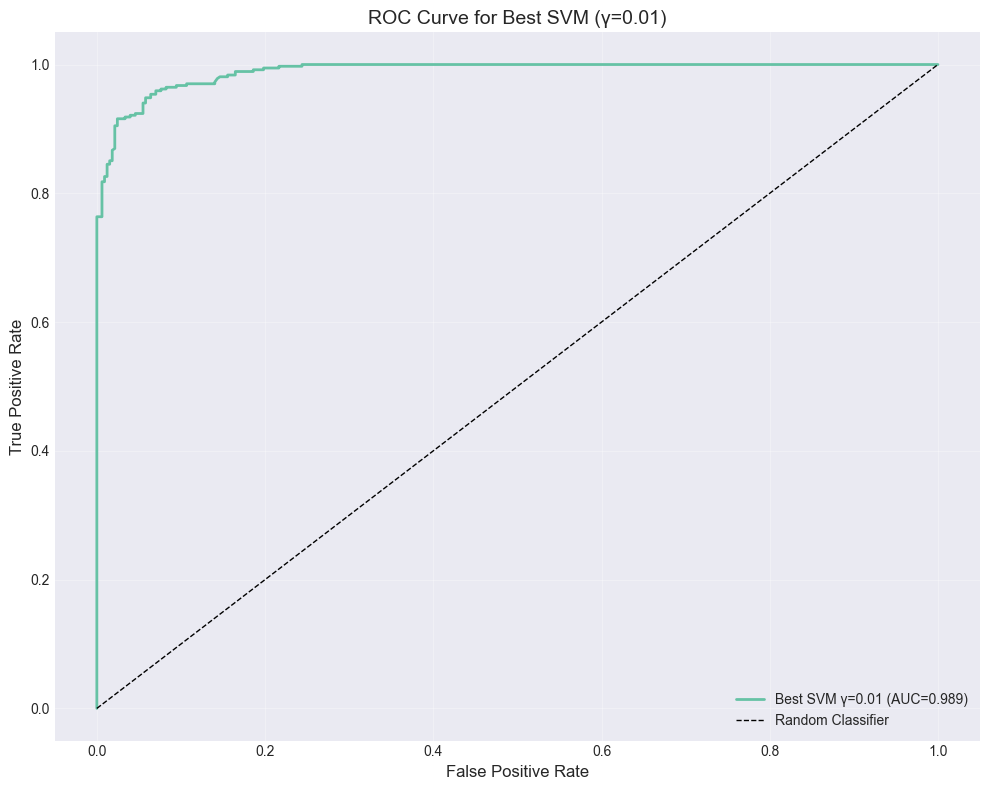

In [17]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Define gamma range: {10^k|-3<=k<=6,k in Z}
gamma_range = [10**k for k in range(-3, 7)]

print("Testing gamma values with 5-fold CV...")

best_gamma = None
best_cv_acc = 0
cv_accuracies = []

# Set up 5-fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#try all the choices of gamma
for gamma in gamma_range:
    C = 1.0 / gamma
    svm = LinearSVC(loss='hinge', C=C, random_state=42)
    
    # Get CV scores
    cv_scores = cross_val_score(svm, lsi_tfidf_lemma_train, y_train, cv=kfold, scoring='accuracy')
    mean_acc = cv_scores.mean()
    cv_accuracies.append(mean_acc)
    print(f"γ = {gamma:8.1e} | CV Accuracy: {mean_acc:.4f}")
    
    if mean_acc > best_cv_acc:
        best_cv_acc = mean_acc
        best_gamma = gamma
print(f"Found the best γ = {best_gamma} with CV Accuracy = {best_cv_acc:.4f}")


# train final model with best gamma and evaluate on test Set

print(f"\nTraining final model with γ = {best_gamma}...")
C_best = 1.0 / best_gamma
svm_best = LinearSVC(loss='hinge', C=C_best, max_iter=1000, random_state=42, dual='auto')
svm_best.fit(lsi_tfidf_lemma_train, y_train)
y_pred = svm_best.predict(lsi_tfidf_lemma_test)
y_scores = svm_best.decision_function(lsi_tfidf_lemma_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='sports')
recall = recall_score(y_test, y_pred, pos_label='sports')
f1 = f1_score(y_test, y_pred, pos_label='sports')
cm = confusion_matrix(y_test, y_pred)
print(f"\nTest Set Results:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(cm)

#Convert labels to binary
y_test_binary = (y_test == 'sports').astype(int)

#Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
roc_auc = auc(fpr, tpr)

#Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Best SVM γ={best_gamma} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve for Best SVM (γ={best_gamma})', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Question 9 - Evaluate a Logistic Classifier

In this section I train and evaluate a logistic classifier, finding the optimal regularization coefficient

In [18]:
from sklearn.linear_model import LogisticRegression

# we can set a very large C value to approximate no regularization (sklearn docs)
def train_clf(x_train, y_train, x_test, y_test, c):
    clf = LogisticRegression(C=c, max_iter=1000, random_state=42)
    clf.fit(lsi_tfidf_lemma_train, y_train)
    y_pred = clf.predict(x_test)
    #for ROC curve
    y_scores = clf.predict_proba(x_test)[:, 1]
    
    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='sports')
    recall = recall_score(y_test, y_pred, pos_label='sports')
    f1 = f1_score(y_test, y_pred, pos_label='sports')

    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nResults for CLF w/ C - 1e15 (approx no regularization)")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)

    return {
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'C': c
    }



Results for CLF w/ C - 1e15 (approx no regularization)
Accuracy:  0.9454
Precision: 0.9484
Recall:    0.9484
F1-Score:  0.9484
Confusion Matrix:
[[309  19]
 [ 19 349]]


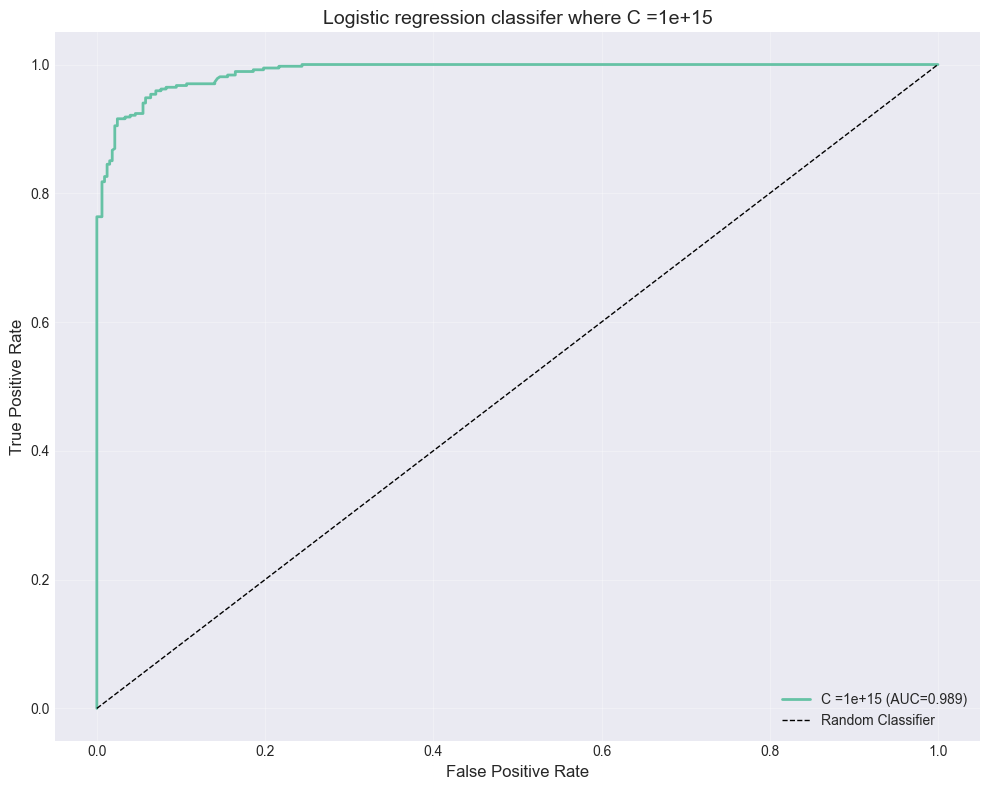

In [19]:
results_clf = train_clf(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test, c=1e15) #very large c

#Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'C ={results_clf["C"]:.0e} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Logistic regression classifer where C ={results_clf["C"]:.0e}', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Training No Regularization model...

No Regularization Test Set Results:
Accuracy:  0.9454
Precision: 0.9484
Recall:    0.9484
F1-Score:  0.9484

Confusion Matrix:
[[309  19]
 [ 19 349]]


Using L1 Regularization
C =  1.0e-05 | CV Accuracy: 0.5029
C =  1.0e-04 | CV Accuracy: 0.5029
C =  1.0e-03 | CV Accuracy: 0.5029
C =  1.0e-02 | CV Accuracy: 0.5029
C =  1.0e-01 | CV Accuracy: 0.9252
C =  1.0e+00 | CV Accuracy: 0.9363
C =  1.0e+01 | CV Accuracy: 0.9486
C =  1.0e+02 | CV Accuracy: 0.9486
C =  1.0e+03 | CV Accuracy: 0.9486
C =  1.0e+04 | CV Accuracy: 0.9486
C =  1.0e+05 | CV Accuracy: 0.9486

Best C for L1 = 10 with CV Accuracy = 0.9486

Training final L1 model with C = 10...

L1 Test Set Results:
Accuracy:  0.9440
Precision: 0.9458
Recall:    0.9484
F1-Score:  0.9471

Confusion Matrix:
[[308  20]
 [ 19 349]]


Using L2 Regularization
C =  1.0e-05 | CV Accuracy: 0.4698
C =  1.0e-04 | CV Accuracy: 0.4712
C =  1.0e-03 | CV Accuracy: 0.6277
C =  1.0e-02 | CV Accuracy: 0.9029
C =  1.0e-01 |

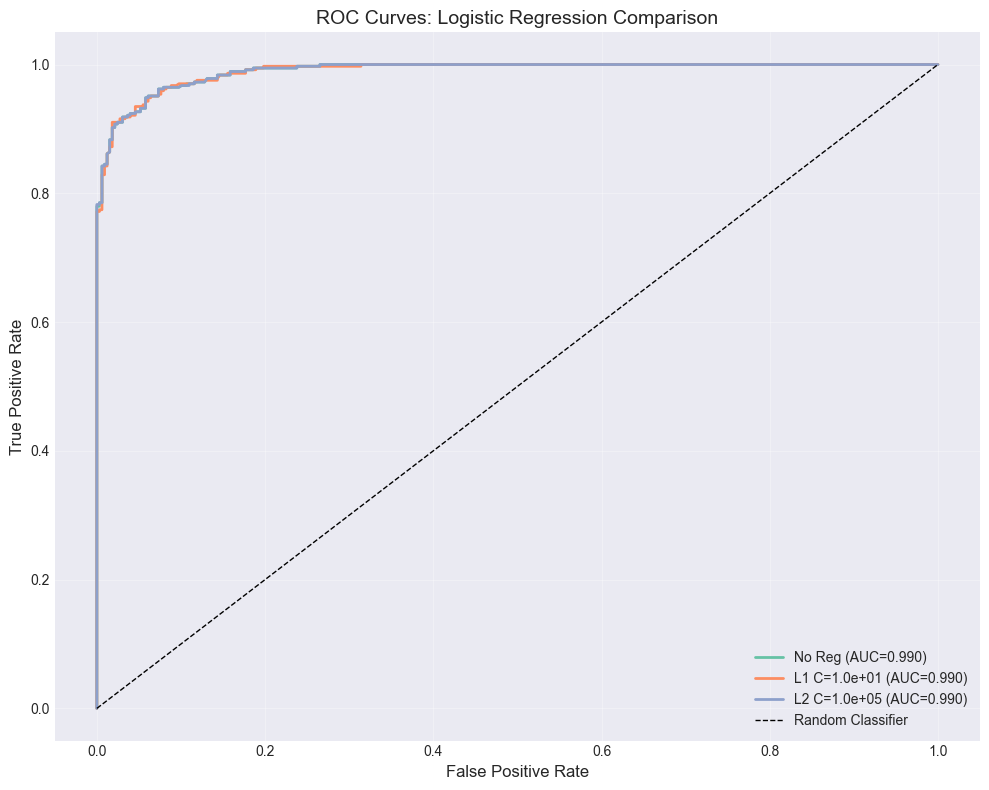

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc)

def train_and_evaluate_logreg(X_train, y_train, X_test, y_test, penalty='l2', 
                               C_range=None, kfold=None):
    #train and eval logistic regression with cross-validation.
    print(f"Using {penalty.upper()} Regularization")
    if C_range is None:
        C_range = [10**k for k in range(-5, 6)]
    if kfold is None:
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    best_C = None
    best_cv_acc = 0
    cv_accuracies = []
    
    # Cross-validation to find best C
    for C in C_range:
        logreg = LogisticRegression(
            penalty=penalty,
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )
        
        cv_scores = cross_val_score(
            logreg, X_train, y_train, 
            cv=kfold, scoring='accuracy'
        )
        mean_acc = cv_scores.mean()
        cv_accuracies.append(mean_acc)
        
        print(f"C = {C:8.1e} | CV Accuracy: {mean_acc:.4f}")
        
        if mean_acc > best_cv_acc:
            best_cv_acc = mean_acc
            best_C = C
    
    print(f"\nBest C for {penalty.upper()} = {best_C} with CV Accuracy = {best_cv_acc:.4f}")
    
    # Train final model with best C
    print(f"\nTraining final {penalty.upper()} model with C = {best_C}...")
    logreg_best = LogisticRegression(
        penalty=penalty,
        C=best_C,
        solver=solver,
        max_iter=1000,
        random_state=42
    )
    logreg_best.fit(X_train, y_train)
    
    #get predict
    y_pred = logreg_best.predict(X_test)
    
    #like decision_function for SVM
    y_scores = logreg_best.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='sports')
    recall = recall_score(y_test, y_pred, pos_label='sports')
    f1 = f1_score(y_test, y_pred, pos_label='sports')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{penalty.upper()} Test Set Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'penalty': penalty,
        'best_C': best_C,
        'cv_accuracy': best_cv_acc,
        'cv_accuracies': cv_accuracies,
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'model': logreg_best
    }

C_range = [10**k for k in range(-5, 6)]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Training No Regularization model...")
clf_no_reg = LogisticRegression(C=1e15, max_iter=1000, random_state=42)
clf_no_reg.fit(lsi_tfidf_lemma_train, y_train)
y_pred_no_reg = clf_no_reg.predict(lsi_tfidf_lemma_test)
y_scores_no_reg = clf_no_reg.predict_proba(lsi_tfidf_lemma_test)[:, 1]

# Calculate metrics for no reg
accuracy_no_reg = accuracy_score(y_test, y_pred_no_reg)
precision_no_reg = precision_score(y_test, y_pred_no_reg, pos_label='sports')
recall_no_reg = recall_score(y_test, y_pred_no_reg, pos_label='sports')
f1_no_reg = f1_score(y_test, y_pred_no_reg, pos_label='sports')
cm_no_reg = confusion_matrix(y_test, y_pred_no_reg)

print(f"\nNo Regularization Test Set Results:")
print(f"Accuracy:  {accuracy_no_reg:.4f}")
print(f"Precision: {precision_no_reg:.4f}")
print(f"Recall:    {recall_no_reg:.4f}")
print(f"F1-Score:  {f1_no_reg:.4f}")
print(f"\nConfusion Matrix:")
print(cm_no_reg)

results_no_reg = {
    'penalty': 'none',
    'best_C': 1e15,
    'y_scores': y_scores_no_reg,
    'accuracy': accuracy_no_reg,
    'precision': precision_no_reg,
    'recall': recall_no_reg,
    'f1': f1_no_reg,
    'gamma': 1e-15
}

print("\n")

# Train L1 and L2 models
results_l1 = train_and_evaluate_logreg(
    lsi_tfidf_lemma_train, y_train,
    lsi_tfidf_lemma_test, y_test,
    penalty='l1',
    C_range=C_range,
    kfold=kfold
)
results_l1['gamma'] = 1.0 / results_l1['best_C']

print("\n")

results_l2 = train_and_evaluate_logreg(
    lsi_tfidf_lemma_train, y_train,
    lsi_tfidf_lemma_test, y_test,
    penalty='l2',
    C_range=C_range,
    kfold=kfold
)
results_l2['gamma'] = 1.0 / results_l2['best_C']

#Make Comparison table
print("Comparing: No Reg vs L1 vs L2")
print(f"{'Metric':<15} {'No Reg':<12} {'L1':<12} {'L2':<12}")
print("-" * 50)
print(f"{'Best C':<15} {'1e10':<12} {results_l1['best_C']:<12.1e} {results_l2['best_C']:<12.1e}")
print(f"{'Accuracy':<15} {results_no_reg['accuracy']:<12.4f} {results_l1['accuracy']:<12.4f} {results_l2['accuracy']:<12.4f}")
print(f"{'Precision':<15} {results_no_reg['precision']:<12.4f} {results_l1['precision']:<12.4f} {results_l2['precision']:<12.4f}")
print(f"{'Recall':<15} {results_no_reg['recall']:<12.4f} {results_l1['recall']:<12.4f} {results_l2['recall']:<12.4f}")
print(f"{'F1-Score':<15} {results_no_reg['f1']:<12.4f} {results_l1['f1']:<12.4f} {results_l2['f1']:<12.4f}")

#ROC Curves
def plot_roc_curve_logreg(results_list, y_test, title):
    plt.figure(figsize=(10, 8))
    
    if isinstance(y_test.iloc[0], str):
        y_test_binary = (y_test == 'sports').astype(int)
    else:
        y_test_binary = y_test
    
    for result in results_list:
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test_binary, result['y_scores'])
        roc_auc = auc(fpr, tpr)
        if result['penalty'] == 'none':
            label = f"No Reg (AUC={roc_auc:.3f})"
        else:
            label = f"{result['penalty'].upper()} C={result['best_C']:.1e} (AUC={roc_auc:.3f})"
        
        plt.plot(fpr, tpr, linewidth=2, label=label)
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot all three
plot_roc_curve_logreg(
    [results_no_reg, results_l1, results_l2],
    y_test,
    'ROC Curves: Logistic Regression Comparison'
)

In [21]:
# Get coefficients from each model
coef_no_reg = clf_no_reg.coef_[0]
coef_l1 = results_l1['model'].coef_[0]
coef_l2 = results_l2['model'].coef_[0]

# Analyze coefficient properties
print(f"{'Model':<12} {'Non-zero':<12} {'Max':<12} {'L2 Norm':<12}")
print("-" * 60)
print(f"{'No Reg':<12} {np.sum(coef_no_reg != 0):<12} {np.max(np.abs(coef_no_reg)):<12.4f} {np.linalg.norm(coef_no_reg):<12.4f}")
print(f"{'L1':<12} {np.sum(coef_l1 != 0):<12} {np.max(np.abs(coef_l1)):<12.4f} {np.linalg.norm(coef_l1):<12.4f}")
print(f"{'L2':<12} {np.sum(coef_l2 != 0):<12} {np.max(np.abs(coef_l2)):<12.4f} {np.linalg.norm(coef_l2):<12.4f}")


Model        Non-zero     Max          L2 Norm     
------------------------------------------------------------
No Reg       25           44.7638      88.1104     
L1           21           44.1342      77.7897     
L2           25           44.7416      88.0698     


### Analysis
- No regularization model: Very weak regularization allows the model to fit training data closely. Possibly prone to overfitting but performance is strong on this test set. (accuracy 0.9454)
- L1 Regularization: Optimial C is low (C=10). Lower C means stronger regularization, but model has slightly lower test accuracy (0.9440). 
- L2 Regularization: Optimal C is high (C=100000). Higher C means weaker regularization. Nearly identical performance to no regularization (accuracy 0.9454 ). 

As regularization strength increases (C decreases), we see a U-shaped error curve:
-No (Very weak) regularization (C=1e15): slight risk of overfitting but still performs well
-Moderate regularization (C=10-100,000): optimal performance
-Very strong regularization (C=0.0001): underfitting / low accuracy

How are the learned coefficients affected?

The learned coefficients show:
- No reg (C=1e15) results in L2 Norm of 88.11 and maximum coefficient magnitude 44.76
- L1 regularization (C=10) results in L2 norm 88.06 and maximum coefficient magnitude 44.13
- L2 regularization (C=10,000) produces similar L2 norm 88.06 and maximum magnitude 44.74 to the unregularized model
- On this test, L1 has 21/25 nozero coefficients while No Reg and L2 have 25/25 non-zero coefficients

[This page](https://stats.stackexchange.com/questions/184019/when-will-l1-regularization-work-better-than-l2-and-vice-versa) helped me understand L1 vs L2 regularization conceptually. Both L1 and L2 regularization address the multicollinearity problem (where two or more independent variables are highly correlated) differently. L1 can potentially result in some coefficients going to 0 resulting in a sparse vector if that is desired. Because of this, it can also be used as a feature selection method if you have to limit how many features you can use. Note that, in the coefficient table I printed, L1 is the only regularization method with some 0 coefficients. L2 regularization helps with multicollinearity by keeping all variables but putting constraints on the coefficient norm but does not frequently fully zero out coefficients. Note that, in our data L2 has no zero coefficients and also has smalled L2 norm. Importantly,  L2 regularization can estimate a coefficient for each feature even if there are more features than observations.



SVM vs Logistic Regression: Decision Boundary Differences
Both logistic regression and linear SVM find a linear decision boundary to separate classes, but they optimize different objectives. Logistic regression minimizes log-loss (cross-entropy) and cares about all data points. Meanwhile, linear SVM minimizes hinge loss and focuses primarily on maximizing the margin between classes, caring mainly about support vectors near the decision boundary and ignoring points far from the margin. In this project, the best SVM and the Logistic Regression models achieved similar performance accuracy. This suggests our data is linearly seperable. The small differences in accuracy (<1%) are not statistically signifigant.

## Question 10 - Naive Bayes
In this section I train and evaluate a GaussianNB classifier.


Results for Gaussian NB Classifier
Accuracy:  0.9052
Precision: 0.8665
Recall:    0.9701
F1-Score:  0.9154
Confusion Matrix:
[[273  55]
 [ 11 357]]


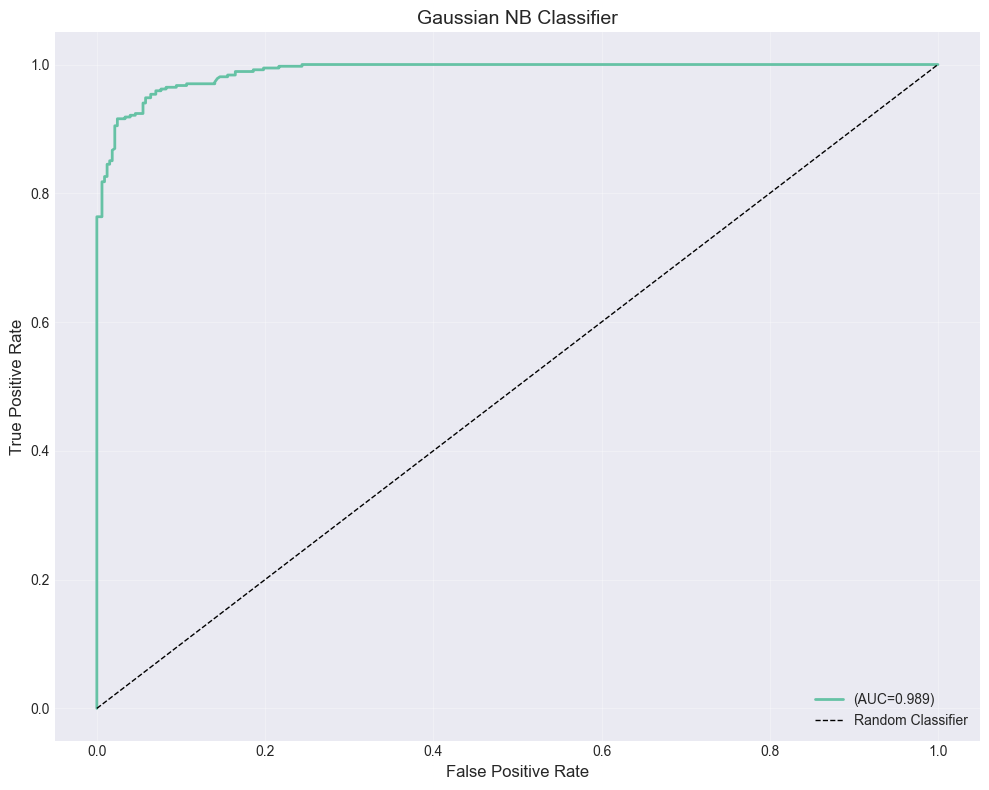

In [22]:
from sklearn.naive_bayes import GaussianNB

def train_gnb(x_train, y_train, x_test, y_test):
    #train gaussian nb classifier
    gnb = GaussianNB()
    gnb.fit(lsi_tfidf_lemma_train, y_train)
    y_pred = gnb.predict(x_test)
    #for ROC curve
    y_scores = gnb.predict_proba(x_test)[:, 1]
    
    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='sports')
    recall = recall_score(y_test, y_pred, pos_label='sports')
    f1 = f1_score(y_test, y_pred, pos_label='sports')

    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\nResults for Gaussian NB Classifier")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)

    return {
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
    }

results_gnb = train_gnb(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test)

#Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'(AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Gaussian NB Classifier', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Question 11 -  Grid Search
In this section, I use grid search to find the best model and the best hyperparmeters.

In [23]:
from sklearn.model_selection import GridSearchCV
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory
import os
import pickle
# print(__doc__)

warnings.filterwarnings('ignore', message='Your stop_words may be inconsistent')
warnings.filterwarnings('ignore', message='The parameter \'token_pattern\' will not be used')
# Define pickle file path
PICKLE_FILE = 'gridsearch_results.pkl'
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=0)
MIN_DF_OPTIONS = [2,5]
TOKENIZER_OPTIONS = [StemTokenizer(), LemmaTokenizer()]
N_FEATURES_OPTIONS = [5,30,100]
C_OPTIONS = [0.1, 1, 10]
pipeline = Pipeline([
    ('vect', CountVectorizer(
        tokenizer=StemTokenizer(),
        stop_words='english',
        min_df=2
    )),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
],
memory=memory
)
# Check if pickle file exists
if os.path.exists(PICKLE_FILE):
    print(f"Loading existing GridSearch results from {PICKLE_FILE}...")
    with open(PICKLE_FILE, 'rb') as f:
        grid = pickle.load(f)
    print("GridSearch results loaded successfully!")
    
else:
    print("No existing results found. Running GridSearch...")
    param_grid = [
        {
            'vect__tokenizer': TOKENIZER_OPTIONS, # 2 choices
            'vect__min_df': MIN_DF_OPTIONS, # 2 choices
            'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
            'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
            'clf': [LinearSVC()], # 1 choice
            'clf__C': [100] # b/c best gamma was 0.01 and C=1.0/gamma
            # 9 choices
        },
        {
            'vect__tokenizer': TOKENIZER_OPTIONS, # 2 choices
            'vect__min_df': MIN_DF_OPTIONS, # 2 choices
            'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
            'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
            'clf': [LogisticRegression(solver='liblinear')], # 1 choice
            'clf__penalty': ["l1"], # 1 choice
            'clf__C': [10] #1 choice of best regularization from before
            # 9 choices
        },
        {
            'vect__tokenizer': TOKENIZER_OPTIONS, # 2 choices
            'vect__min_df': MIN_DF_OPTIONS, # 2 choices
            'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
            'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
            'clf': [LogisticRegression(solver= 'lbfgs')], # 1 choice
            'clf__penalty': ["l2"], # 1 choice
            'clf__C': [100000] #1 choice of best regularization from before
            # 9 choices
        },
        {
            'vect__tokenizer': TOKENIZER_OPTIONS, # 2 choices
            'vect__min_df': MIN_DF_OPTIONS, # 2 choices
            'reduce_dim': [TruncatedSVD(), NMF()], # 2 choices
            'reduce_dim__n_components': N_FEATURES_OPTIONS, # 3 choices
            'clf': [GaussianNB()]
            # 9 choices
        },
    ]
    print("Starting GridSearch (this may take a while)...")
    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy', verbose=1) #verbose to get prints
    grid.fit(train['full_text_cleaned'], train['root_label']) #using cleaned data from earlier
    print(f"\nSaving GridSearch results to {PICKLE_FILE}...")
    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(grid, f)
    print("Results saved successfully!")
    rmtree(cachedir)

Loading existing GridSearch results from gridsearch_results.pkl...
GridSearch results loaded successfully!


In [24]:
# Get top 5 combinations from CV
results_df = pd.DataFrame(grid.cv_results_)
top_5 = results_df['rank_test_score'].nlargest(5, keep='first').index
print("\nTop 5 Combinations (from CV)")
for i, idx in enumerate(top_5, 1):
    params = results_df.loc[idx, 'params']
    cv_score = results_df.loc[idx, 'mean_test_score']

    print(f"\nCombination {i}")
    print(f"Parameters: {params}")
    print(f"CV Accuracy: {cv_score:.4f}")

    model = pipeline.set_params(**params)
    model.fit(train['full_text_cleaned'], train['root_label'])
    y_pred = model.predict(test['full_text_cleaned'])

    print(f"\nTest Set Performance:")
    print(f"Accuracy: {accuracy_score(test['root_label'], y_pred):.4f}")
    print(f"Precision: {precision_score(test['root_label'], y_pred, pos_label='sports'):.4f}")
    print(f"Recall: {recall_score(test['root_label'], y_pred, pos_label='sports'):.4f}")
    print(f"F1-Score: {f1_score(test['root_label'], y_pred, pos_label='sports'):.4f}")


Top 5 Combinations (from CV)

Combination 1
Parameters: {'clf': GaussianNB(), 'reduce_dim': TruncatedSVD(), 'reduce_dim__n_components': 5, 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x00000282DEE97F40>}
CV Accuracy: 0.8478

Test Set Performance:
Accuracy: 0.8190
Precision: 0.7500
Recall: 0.9864
F1-Score: 0.8521

Combination 2
Parameters: {'clf': GaussianNB(), 'reduce_dim': TruncatedSVD(n_components=5), 'reduce_dim__n_components': 5, 'vect__min_df': 5, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x00000282DEE97F40>}
CV Accuracy: 0.8683

Test Set Performance:
Accuracy: 0.8448
Precision: 0.7790
Recall: 0.9864
F1-Score: 0.8705

Combination 3
Parameters: {'clf': GaussianNB(), 'reduce_dim': TruncatedSVD(n_components=5), 'reduce_dim__n_components': 5, 'vect__min_df': 2, 'vect__tokenizer': <__main__.StemTokenizer object at 0x00000282DEE97AC0>}
CV Accuracy: 0.8784

Test Set Performance:
Accuracy: 0.8563
Precision: 0.7939
Recall: 0.9837
F1-Score: 0.8786



## Question 12 - Comparing TF-IDF and Pretrained Embeddings
Now I will compare whether TF-IDF or pretrained embeddings perform better when the classifier is fixed.


TF-IDF + LSI:

Results for SVM where: γ = 0.01 (C = 100.0)
Accuracy:  0.9454
Precision: 0.9484
Recall:    0.9484
F1-Score:  0.9484
Confusion Matrix:
[[309  19]
 [ 19 349]]

Glove:

Results for SVM where: γ = 0.01 (C = 100.0)
Accuracy:  0.9612
Precision: 0.9776
Recall:    0.9484
F1-Score:  0.9628
Confusion Matrix:
[[320   8]
 [ 19 349]]

LLM:

Results for SVM where: γ = 0.01 (C = 100.0)
Accuracy:  0.9583
Precision: 0.9748
Recall:    0.9457
F1-Score:  0.9600
Confusion Matrix:
[[319   9]
 [ 20 348]]


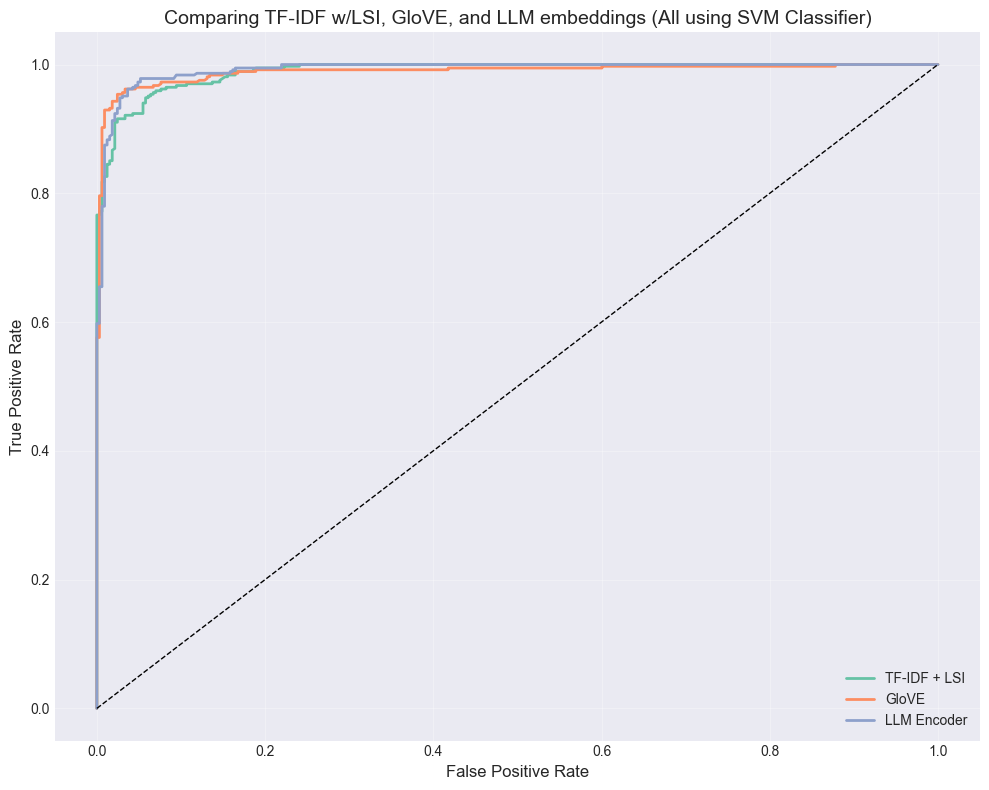

In [25]:

#Make use of previosuly saved lsi_tdidf, glove_emb, and transformer matrices. 
#Train and test an SVM classifier on them to compare. Hold gamma at 0.01 to "keep it fixed"
print("\nTF-IDF + LSI:")
results_svm_tfidf_lsi = train_svm(lsi_tfidf_lemma_train, y_train, lsi_tfidf_lemma_test, y_test, gamma=0.01)
print("\nGlove:")
results_svm_glove = train_svm(train_glove_emb, y_train, test_glove_emb, y_test, gamma=0.01)
print("\nLLM:")
results_svm_transformer = train_svm(train_transformer, y_train, test_transformer, y_test, gamma=0.01)

def compare_embed_roc_curve(results_list, label_list, y_test, title):
    plt.figure(figsize=(10, 8))
    if isinstance(y_test.iloc[0], str):
        y_test_binary = (y_test == 'sports').astype(int)
    else:
        y_test_binary = y_test
    
    for i in range(len(results_list)):
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test_binary, results_list[i]['y_scores'])
        roc_auc = auc(fpr, tpr)
        
        # Plot
        label = label_list[i]
        plt.plot(fpr, tpr, linewidth=2, label=label)
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

labels = ["TF-IDF + LSI", "GloVE", "LLM Encoder"]
plot_title = "Comparing TF-IDF w/LSI, GloVE, and LLM embeddings (All using SVM Classifier)"
compare_embed_roc_curve([results_svm_tfidf_lsi, results_svm_glove, results_svm_transformer], labels, y_test, plot_title)



### Interpretation

GloVe performs best (96.12% accuracy), followed closely by LLM (95.83%), with TF-IDF + LSI trailing slightly (94.54%). However, these differences are relatively small (only ~1.6% separating best from worst).

Most notably, GloVE and LLM have a smaller false positive rate. TF-IDF has 19 false psoitives while GloVe has 8 and LLM has 9. (All three methods have similar false negative rates). 

Glove achieves a better false positive rate than TF-IDF because GloVe captures word co-occurrence patterns that help it differentiate sports terminology from climate terminology. The average Glove OOV rate was 1.34% (from Q5), which is low, so we know GloVE was able to leverage its pretrained semantic knowledge when developing the embeddings. 

LLM performs similarly to GloVE, which suggests that for this simple binary classification task, word level semantic knowledge is as effective as the LLM's contextual understanding. Since the two topics in this class have pretty different vocabularies (sports: "football", "touchdown", "dunk" and climate: "rain", "storm", "flooding"), its likely that contextualization does not bring as much improvement. Contextualization might make more of a difference if there was more overlap in the vocabularies or other kinds of ambiguity. 

## Question 13 - Comparing UMAP Visualization
I will leverage UMAP in order to compare a 2D representation of GLoVE document embeddings vs random embeddings

C:\Users\jilli\.conda\envs\ece219\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


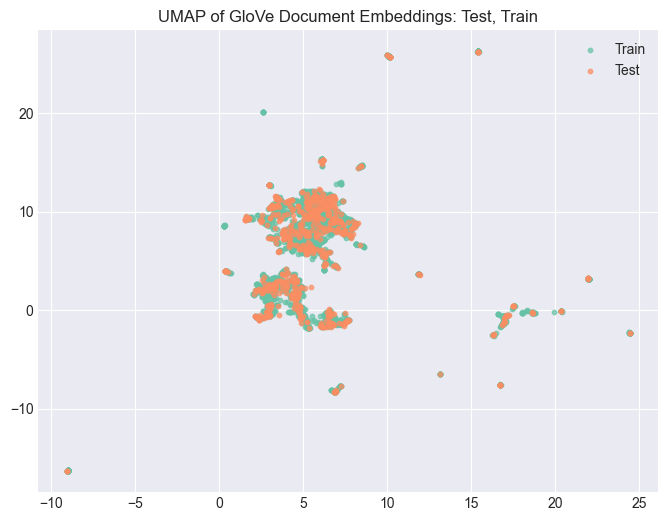

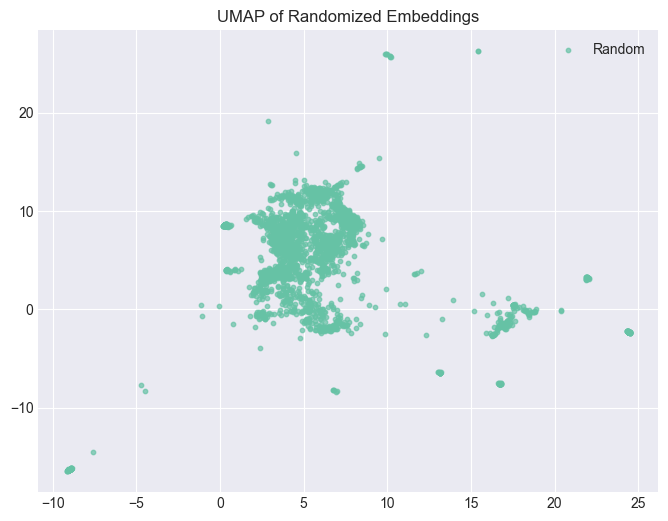

In [26]:
import umap
#use umap to represent vectors in 2d
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

train_2d_umap = reducer.fit_transform(train_glove_emb)
test_2d_umap = reducer.transform(test_glove_emb)

rng = np.random.default_rng(42)
random_emb = rng.normal(
    loc=0.0,
    scale=1.0,
    size=(2780, 300)
)
random_2d_umap = reducer.transform(random_emb)

plt.figure(figsize=(8, 6))
plt.scatter(train_2d_umap[:, 0], train_2d_umap[:, 1], s=10, label="Train", alpha=0.7)
plt.scatter(test_2d_umap[:, 0], test_2d_umap[:, 1], s=10, label="Test", alpha=0.7)
plt.legend()
plt.title("UMAP of GloVe Document Embeddings: Test, Train")

plt.figure(figsize=(8, 6))
plt.scatter(random_2d_umap[:, 0], random_2d_umap[:, 1], s=10, alpha=0.7, label="Random")
plt.legend()
plt.title("UMAP of Randomized Embeddings")
plt.show()

Above, we see that the randomized embeddings graph has a similar shape to the Glove Document Embeddings graph, but the Glove Document Embeddings graph has approximately 3 clusters that are more obvious/ tightly-formed than the randomized embeddings, which only has two loosely-formed clusters.

## Question 14 - Multiclass Classification
Now we move to a multiclass classification problem where I aim to learn classifiers for the 10 classes in leaf_label.

In [27]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier


def train_multiclass_nb(nb, x_train, y_train, x_test, y_test):
    nb.fit(x_train, y_train)
    y_pred = nb.predict(x_test)
    y_scores = nb.predict_proba(x_test)
    
    #metrics with macro averaging
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    #confusion matrix
    label_order = ["basketball", "baseball", "tennis", "football", "soccer",
                   "forest fire", "flood", "earthquake", "drought", "heatwave"]
    labels_in_data = [label for label in label_order if label in y_test.values]
    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_in_data)
    
    print(f"\nResults for Gaussian NB Classifier (Multiclass)")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"Confusion Matrix (10x10):")
    print(conf_matrix)
    
    return {
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
    }


def train_svm_ovo(wrap_classifier, x_train, y_train, x_test, y_test, gamma, balance = False):
    c = 1.0 / gamma
    if balance:
        base_svm = LinearSVC(loss='hinge', class_weight='balanced', C=c, random_state=42, max_iter=10000)
    else:
        base_svm = LinearSVC(loss='hinge', C=c, random_state=42, max_iter=10000)
    if wrap_classifier == "OVO":
        svm_with_wrapper = OneVsOneClassifier(base_svm)
    else:
        svm_with_wrapper = OneVsRestClassifier(base_svm)
    svm_with_wrapper.fit(x_train, y_train)
    
    y_pred = svm_with_wrapper.predict(x_test)
    y_scores = svm_with_wrapper.decision_function(x_test)
    
    # Metrics with macro averaging for multiclass
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    #confusion matrix
    label_order = ["basketball", "baseball", "tennis", "football", "soccer",
                   "forest fire", "flood", "earthquake", "drought", "heatwave"]
    labels_in_data = [label for label in label_order if label in y_test.values]
    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_in_data)
    
    print(f"\nResults for SVM {wrap_classifier} where: γ = {gamma} (C = {c})")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1-Score (macro):  {f1:.4f}")
    print(f"Confusion Matrix ({len(labels_in_data)}x{len(labels_in_data)}):")
    print(conf_matrix)
    
    return {
        'y_pred': y_pred,
        'y_scores': y_scores,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'gamma': gamma,
        'C': c,
        'labels': labels_in_data
    }

In [28]:
#Using GaussianNB as Tf-IDF+LSI, Glove, and Transformer embeddings are dense
y_train_multi = train["leaf_label"]
y_test_multi = test["leaf_label"]
print("\n****************************")
print("USING TF-IDF + LSI WITH k=25")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01)
print("\n****************************")
print("USING GLOVE EMBEDDINGS")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), train_glove_emb, y_train_multi, test_glove_emb, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01)
print("\n****************************")
print("USING LLM EMBEDDINGS")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), train_transformer, y_train_multi, test_transformer, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01)


****************************
USING TF-IDF + LSI WITH k=25
****************************

Results for Gaussian NB Classifier (Multiclass)
Accuracy:  0.6566
Precision (macro): 0.7045
Recall (macro):    0.6605
F1-Score (macro):  0.6709
Confusion Matrix (10x10):
[[70  9 10  1  0  0  0  0  0  0]
 [ 1 37 29  2  0  0  2  0  0  4]
 [ 0  6 57  1  3  0  2  0  0  0]
 [ 0  6  4 49  1  0  0  0  0  1]
 [ 0  5  9  3 55  0  0  0  0  1]
 [ 0  4  9  0  1 20  0  0  6 33]
 [ 0  0  1  0  0  5 55  0  0  5]
 [ 0  1  9  0  0  0  0 43  0  1]
 [ 0  1  3  0  0  1  0  0 54  9]
 [ 0  3 12  0  0 30  3  0  2 17]]

Results for SVM OVO where: γ = 0.01 (C = 100.0)
Accuracy:  0.7471
Precision (macro): 0.7558
Recall (macro):    0.7491
F1-Score (macro):  0.7509
Confusion Matrix (10x10):
[[82  4  4  0  0  0  0  0  0  0]
 [ 2 58  6  1  0  4  1  0  0  3]
 [ 0 11 52  0  3  1  1  0  0  1]
 [ 0  2  0 57  2  0  0  0  0  0]
 [ 0  2  7  1 63  0  0  0  0  0]
 [ 0  1  3  0  0 18  0  2  4 45]
 [ 0  1  0  0  0  4 60  0  0  1]
 [ 0  2 

### Analysising Confusion Matrix
The confusion matrixes show a strong diagonal (correct predictions), indicating good performance. Glove SVM OVR actually has the best accuracy (0.76). However, there is a pattern that exists across all models showing a confusion between "Heatwave" (Class 9) and "Forest Fire" (Class 5) classes. Articles that talk about heatwaves might also be talking about widfire risk or use terms that overlap between the two classes like "dry", "hot", or "emergency". Since the confusion exists in both directions (forest fire is miscclassified as heatwave and heatwave is missclassified as forest fire) these two topics are basically the ssame thing in the models view. Some minor confusion also occurs between some sports classes (like baseball and tennis getting mixed up slightly).

One important thing to note is that there is not a lot of cross-category confusion between sports leaf labels and climate leaf labels. We can see this because the top right and bottom left corners of the matrix are basically all close to 0. 

In the next part, I will merge the forest fire and heatwave labels and recompute the confusion matrices

### Merging labels

In [29]:
def merge_labels(y, merge_mapping):
    y_copy = y.copy()
    for old_label, new_label in merge_mapping.items():
        y_copy = y_copy.replace(old_label, new_label)
    return y_copy

merge_mapping = {
    'forest fire': 'heat_or_fire',
    'heatwave': 'heat_or_fire'
}

y_train_multi = merge_labels(train["leaf_label"],merge_mapping)
y_test_multi = merge_labels(test["leaf_label"], merge_mapping)
print("\n****************************")
print("USING TF-IDF + LSI WITH k=25")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01)
print("\n****************************")
print("USING GLOVE EMBEDDINGS")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), train_glove_emb, y_train_multi, test_glove_emb, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01)
print("\n****************************")
print("USING LLM EMBEDDINGS")
print("****************************")
multi_nb=train_multiclass_nb(GaussianNB(), train_transformer, y_train_multi, test_transformer, y_test_multi)
multi_svm_ovo=train_svm_ovo("OVO", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01)
multi_svm_ovo=train_svm_ovo("OVR", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01)


****************************
USING TF-IDF + LSI WITH k=25
****************************

Results for Gaussian NB Classifier (Multiclass)
Accuracy:  0.7471
Precision (macro): 0.8024
Recall (macro):    0.7547
F1-Score (macro):  0.7664
Confusion Matrix (10x10):
[[70  9 10  1  0  0  0  0]
 [ 1 37 28  2  0  2  0  0]
 [ 0  6 57  1  3  2  0  0]
 [ 0  6  4 49  1  0  0  0]
 [ 0  5  9  3 55  0  0  0]
 [ 0  0  1  0  0 55  0  0]
 [ 0  1  9  0  0  0 43  0]
 [ 0  1  3  0  0  0  0 54]]

Results for SVM OVO where: γ = 0.01 (C = 100.0)
Accuracy:  0.8563
Precision (macro): 0.8770
Recall (macro):    0.8527
F1-Score (macro):  0.8635
Confusion Matrix (8x8):
[[82  4  3  0  0  0  0  0]
 [ 2 57  5  1  0  0  0  0]
 [ 0  9 46  0  3  1  0  0]
 [ 0  2  0 57  2  0  0  0]
 [ 0  2  7  1 63  0  0  0]
 [ 0  0  0  0  0 59  0  0]
 [ 0  1  1  0  0  0 47  0]
 [ 0  1  0  0  0  0  0 60]]

Results for SVM OVR where: γ = 0.01 (C = 100.0)
Accuracy:  0.8549
Precision (macro): 0.8636
Recall (macro):    0.8531
F1-Score (macro):  

Merging the "forest fire" and "heatwave" labels into a single "fire_heat_events" class produces large performance differences! After merging, accuracy improved by 11-16 percentage points across all embedding methods. The best-performing model, GloVe embeddings with SVM OvR, improved from 76.44% to 87.79% accuracy (+11.35 points), while LLM embeddings with SVM OvO saw the largest gain from 70.83% to 87.07% (+16.24 points). The merged "heat_or_fire" class is now almost-perfectly classified, with minimal confusion to other categories. This demonstrates that these two event types share overlapping vocabulary and contextual patterns in news coverage. The improvements generalized across all classifiers (Naive Bayes, SVM OvO, and SVM OvR), which indicates that the merge addressed a fundamental limitation in the label granularity rather than a model-specific weakness.

Now let's test whether balancing the classes has any affect for the SVM OVO and SVM OVR classifiers

### Class Imbalance

In [30]:
print("\n****************************")
print("USING TF-IDF + LSI WITH k=25")
print("****************************")
multi_svm_ovo=train_svm_ovo("OVO", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01, balance = True)
multi_svm_ovo=train_svm_ovo("OVR", lsi_tfidf_lemma_train, y_train_multi, lsi_tfidf_lemma_test, y_test_multi, gamma=0.01, balance = True)
print("\n****************************")
print("USING GLOVE EMBEDDINGS")
print("****************************")
multi_svm_ovo=train_svm_ovo("OVO", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01, balance = True)
multi_svm_ovo=train_svm_ovo("OVR", train_glove_emb, y_train_multi, test_glove_emb, y_test_multi, gamma=0.01, balance = True)
print("\n****************************")
print("USING LLM EMBEDDINGS")
print("****************************")
multi_svm_ovo=train_svm_ovo("OVO", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01, balance = True)
multi_svm_ovo=train_svm_ovo("OVR", train_transformer, y_train_multi, test_transformer, y_test_multi, gamma=0.01, balance = True)


****************************
USING TF-IDF + LSI WITH k=25
****************************

Results for SVM OVO where: γ = 0.01 (C = 100.0)
Accuracy:  0.8563
Precision (macro): 0.8671
Recall (macro):    0.8615
F1-Score (macro):  0.8627
Confusion Matrix (8x8):
[[82  4  4  0  0  0  0  0]
 [ 2 58  6  1  0  1  0  0]
 [ 0 14 51  0  3  1  0  0]
 [ 0  2  0 57  2  0  0  0]
 [ 0  2  7  1 63  0  0  0]
 [ 0  1  0  0  0 62  0  0]
 [ 0  3  2  0  0  0 48  0]
 [ 0  2  0  0  0  0  1 60]]

Results for SVM OVR where: γ = 0.01 (C = 100.0)
Accuracy:  0.8491
Precision (macro): 0.8551
Recall (macro):    0.8576
F1-Score (macro):  0.8550
Confusion Matrix (8x8):
[[82  3  3  2  0  0  0  0]
 [ 3 56  4  2  1  3  0  1]
 [ 0  8 51  0  8  1  0  0]
 [ 0  1  0 58  2  0  0  0]
 [ 0  2  4  1 66  0  0  0]
 [ 0  1  0  0  0 61  0  0]
 [ 0  3  2  0  1  0 48  0]
 [ 0  3  1  0  0  0  0 59]]

****************************
USING GLOVE EMBEDDINGS
****************************

Results for SVM OVO where: γ = 0.01 (C = 100.0)
Accuracy:

The results of applying class_weight = "balance" show minimal accuracy changes (~0.6% change), indicating that class imbalance was not a significant factor in the merged 9-class dataset. OvR models showed slightly more sensitivity to class weighting than OvO. OvR's one-vs-all formulation is more likely to be affected by class imbalance, so this makes sense. To call out one instance: on LLM embeddings OvR accuracy improved from 84.77% to 85.34% (+0.57%), while OvO changed from 87.07% to 87.21% (+0.14%). In general, the F1 scores increased by 0.3-0.5 points, which suggests that class weighting creates some improvements in minority class performance without harming overall accuracy. This contrasts sharply with the dramatic 11-16% improvements from merging forest fire and heatwave, so the earlier less-than-ideal performance was caused moreso by the label confusion.